<a href="https://colab.research.google.com/github/i-ganza007/Match_Backend/blob/main/DraftBreedRecogntion_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

# Task
Develop a livestock breed classification model using ResNet50. Load and preprocess images from "/content/drive/MyDrive/Data" (resized to 224x224, using ResNet50 preprocessing), and perform a 70/15/15 stratified split. Implement a two-phase training strategy: first, train a custom classification head (with GlobalAveragePooling2D and 0.5 Dropout) for 20 epochs with the ResNet50 backbone frozen (Adam, LR=1e-3); then, fine-tune the last 20 layers of the backbone for 30 more epochs with a reduced learning rate (Adam, LR=1e-5). Evaluate the final model on the test set and visualize the accuracy and loss curves for both phases.

## Data Preparation and Label Validation

### Subtask:
Prepare the livestock image dataset by mounting Google Drive, collecting file paths/labels, and performing a stratified 70/15/15 split.


**Reasoning**:
I will start by mounting Google Drive to access the dataset stored in the specified path.



In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

data_path = '/content/drive/MyDrive/Data'
print(f'Drive mounted. Data path set to: {data_path}')

Mounted at /content/drive
Drive mounted. Data path set to: /content/drive/MyDrive/Data


**Reasoning**:
I will list the subdirectories in the data folder to identify the livestock breed classes and check for any hidden files or inconsistencies.



In [3]:
all_items = os.listdir(data_path)

# Filter to include only directories (representing classes) and exclude hidden files
classes = [item for item in all_items if os.path.isdir(os.path.join(data_path, item)) and not item.startswith('.')]

# Sort classes for consistent label mapping (important for class weights)
classes = sorted(classes)

print(f'Found {len(classes)} classes (sorted): {classes}')

# Check for any unexpected files in the root directory
non_dir_items = [item for item in all_items if not os.path.isdir(os.path.join(data_path, item))]
if non_dir_items:
    print(f'Warning: Found non-directory items in data path: {non_dir_items}')

Found 14 classes (sorted): ['brown_swiss_cow', 'dorper_sheep', 'duroc_pig', 'fresian_cow', 'girolando_cow', 'indigenous_ankole_cow', 'indigenous_goat', 'indigenous_pig', 'jersey_cow', 'landrace_pig', 'large_white_pig', 'merino_sheep', 'pietrain_pig', 'sahiwal_cow']


**Reasoning**:
I will traverse the class directories to collect all image file paths and their corresponding labels, storing them in a pandas DataFrame for easier splitting and manipulation.



In [4]:
label_to_int = {label: idx for idx, label in enumerate(classes)}

data = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

for label in classes:
    class_path = os.path.join(data_path, label)
    for filename in os.listdir(class_path):
        if filename.lower().endswith(valid_extensions):
            filepath = os.path.join(class_path, filename)
            data.append({'filepath': filepath, 'label': label})

# Create a DataFrame
df = pd.DataFrame(data)
print(f'Total images found: {len(df)}')
print(df.head())

# Check class distribution
print('\nClass distribution:')
print(df['label'].value_counts())

Total images found: 689
                                            filepath            label
0  /content/drive/MyDrive/Data/brown_swiss_cow/0_...  brown_swiss_cow
1  /content/drive/MyDrive/Data/brown_swiss_cow/1_...  brown_swiss_cow
2  /content/drive/MyDrive/Data/brown_swiss_cow/2_...  brown_swiss_cow
3  /content/drive/MyDrive/Data/brown_swiss_cow/3_...  brown_swiss_cow
4  /content/drive/MyDrive/Data/brown_swiss_cow/4_...  brown_swiss_cow

Class distribution:
label
girolando_cow            67
indigenous_ankole_cow    58
fresian_cow              57
dorper_sheep             56
landrace_pig             56
brown_swiss_cow          54
merino_sheep             49
large_white_pig          48
jersey_cow               46
pietrain_pig             43
sahiwal_cow              42
indigenous_goat          42
duroc_pig                38
indigenous_pig           33
Name: count, dtype: int64


**Reasoning**:
I will perform a stratified split of the dataset into training (70%), validation (15%), and testing (15%) sets using `train_test_split` twice to ensure class proportions are maintained.



In [5]:
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f'Training samples: {len(train_df)}')
print(f'Validation samples: {len(val_df)}')
print(f'Testing samples: {len(test_df)}')

# Verify stratification
print('\nValidation set class distribution:')
print(val_df['label'].value_counts())

Training samples: 482
Validation samples: 103
Testing samples: 104

Validation set class distribution:
label
girolando_cow            10
dorper_sheep              8
landrace_pig              8
brown_swiss_cow           8
fresian_cow               8
indigenous_ankole_cow     8
jersey_cow                7
sahiwal_cow               7
large_white_pig           7
indigenous_goat           7
merino_sheep              7
pietrain_pig              7
duroc_pig                 6
indigenous_pig            5
Name: count, dtype: int64


## Model Architecture and Loss Configuration

### Subtask:
Initialize the ResNet50 base model and append a custom classification head.


**Reasoning**:
I will import the required TensorFlow and Keras modules, initialize the ResNet50 base model with pre-trained ImageNet weights, and append a custom classification head consisting of a GlobalAveragePooling2D layer, a 0.5 Dropout layer, and a Dense softmax layer for the 14 livestock classes.



In [6]:
print('\nComputing class weights...')
y_train_int = train_df['label'].map(label_to_int).values
unique_int = np.unique(y_train_int)
weights = compute_class_weight('balanced', classes=unique_int, y=y_train_int)
class_weight_dict = dict(zip(unique_int, weights))

# Apply 10x multiplier to rare breeds (adjust list as needed)
rare_breeds = ['Sahiwal', 'Pietrain']  # Add 'Ankole' etc. if needed
for breed in rare_breeds:
    if breed in label_to_int:
        idx = label_to_int[breed]
        if idx in class_weight_dict:
            class_weight_dict[idx] *= 10.0
            print(f'Applied 10x weight multiplier to rare breed: {breed} (index {idx})')

print('Class weight dictionary:', class_weight_dict)

# Define label-smoothed loss
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# Define the number of classes
num_classes = len(classes)

# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom head with increased dropout (0.6 instead of 0.5)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
print(f'Model initialized for {num_classes} classes.')
model.summary()


Computing class weights...
Class weight dictionary: {np.int64(0): np.float64(0.9060150375939849), np.int64(1): np.float64(0.8827838827838828), np.int64(2): np.float64(1.2751322751322751), np.int64(3): np.float64(0.8607142857142858), np.int64(4): np.float64(0.7325227963525835), np.int64(5): np.float64(0.8397212543554007), np.int64(6): np.float64(1.187192118226601), np.int64(7): np.float64(1.4968944099378882), np.int64(8): np.float64(1.0758928571428572), np.int64(9): np.float64(0.8827838827838828), np.int64(10): np.float64(1.0126050420168067), np.int64(11): np.float64(1.0126050420168067), np.int64(12): np.float64(1.1476190476190475), np.int64(13): np.float64(1.187192118226601)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model initialized for 14 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,616,398 (90.09 MB)

 Trainable params: 23,563,278 (89.89 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Data Augmentation and Flow Setup

### Subtask:
Configure the data augmentation pipeline and set up data generators for the training, validation, and test sets.


**Reasoning**:
I will import the ImageDataGenerator and ResNet50's preprocess_input, then configure the training generator with the specified augmentations and the validation/test generators with only preprocessing, finally creating the flow from the respective dataframes.



In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    classes=classes  # enforce consistent class order
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

print(f'\nTotal training samples: {train_generator.n}')
print(f'Total validation samples: {val_generator.n}')
print(f'Total test samples: {test_generator.n}')
print(f'Class indices: {train_generator.class_indices}')

Found 482 validated image filenames belonging to 14 classes.
Found 103 validated image filenames belonging to 14 classes.
Found 104 validated image filenames belonging to 14 classes.

Total training samples: 482
Total validation samples: 103
Total test samples: 104
Class indices: {'brown_swiss_cow': 0, 'dorper_sheep': 1, 'duroc_pig': 2, 'fresian_cow': 3, 'girolando_cow': 4, 'indigenous_ankole_cow': 5, 'indigenous_goat': 6, 'indigenous_pig': 7, 'jersey_cow': 8, 'landrace_pig': 9, 'large_white_pig': 10, 'merino_sheep': 11, 'pietrain_pig': 12, 'sahiwal_cow': 13}


## Phase A: Training the Head (Epochs 1-20)

### Subtask:
Freeze all backbone layers and train only the custom classification head for 20 epochs using the Adam optimizer with a learning rate of 1e-3.


**Reasoning**:
I will freeze the ResNet50 backbone, compile the model with the Adam optimizer at a learning rate of 1e-3, and train the classification head for 20 epochs using the training and validation generators, storing the results in history_phase_a.



In [8]:
base_model.trainable = False
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

history_phase_a = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

print('\nPhase A training complete.')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 241s 14s/step - accuracy: 0.0818 - loss: 3.8606 - val_accuracy: 0.2330 - val_loss: 2.3772
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2379 - loss: 2.9472 - val_accuracy: 0.4272 - val_loss: 1.9169
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3163 - loss: 2.5744 - val_accuracy: 0.5340 - val_loss: 1.8039
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3830 - loss: 2.2362 - val_accuracy: 0.6019 - val_loss: 1.6897
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4642 - loss: 2.0695 - val_accuracy: 0.5631 - val_loss: 1.6677
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5246 - loss: 1.9002 - val_accuracy: 0.5922 - val_loss: 1.6575
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5331 - loss: 1.9216 - val_accuracy: 0.6117 - val_loss: 1.6309
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6050 - loss: 1.6250 - val_accuracy: 0.6408 - val_los

**Reasoning**:
The training of the custom head (Phase A) has completed successfully. I will now proceed to Phase B as specified in the task: unfreezing the last 20 layers of the ResNet50 backbone and fine-tuning the model for 30 additional epochs at a lower learning rate of 1e-5. Following training, I will evaluate the model on the test set and visualize the accuracy and loss curves for both training phases.



In [9]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

print('Starting Phase B: Fine-tuning the last 20 layers...')
history_phase_b = model.fit(
    train_generator,
    epochs=50,
    initial_epoch=20,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

print('\nPhase B training complete.')

Starting Phase B: Fine-tuning the last 20 layers...
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6763 - loss: 1.4319 - val_accuracy: 0.6893 - val_loss: 1.6099
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7210 - loss: 1.3324 - val_accuracy: 0.6893 - val_loss: 1.6128
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7580 - loss: 1.2671 - val_accuracy: 0.6893 - val_loss: 1.6113
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7300 - loss: 1.2998 - val_accuracy: 0.6893 - val_loss: 1.6058
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7499 - loss: 1.2579 - val_accuracy: 0.6796 - val_loss: 1.6057
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7551 - loss: 1.2108 - val_accuracy: 0.6796 - val_loss: 1.6143
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7358 - loss: 1.2266 - val_accuracy: 0.6699 - val_loss: 1.6156
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accura

# Task
Perform a detailed evaluation of the livestock breed classification model by generating a confusion matrix and a classification report (including precision, recall, and F1-score) for all 14 breeds using the test generator. Visualize the model's performance with a grid showing a selection of test images labeled with their predicted and actual classes. Save the final fine-tuned ResNet50 model to "/content/drive/MyDrive/Data/livestock_resnet50_final.h5" for future use. Finally, provide a summary of the project results, highlighting the final test accuracy and analyzing the training and validation curves.

## Detailed Classification Evaluation

### Subtask:
Generate a confusion matrix and a classification report for the 14 breeds using the test dataset to analyze model performance.


**Reasoning**:
I will import the necessary evaluation metrics and visualization libraries, generate predictions on the test set, and then produce a classification report and a confusion matrix heatmap as requested.




Evaluating the final model on the test set (single pass)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.7562 - loss: 1.3844
Test Accuracy (single): 0.7212
Test Loss (single): 1.4650


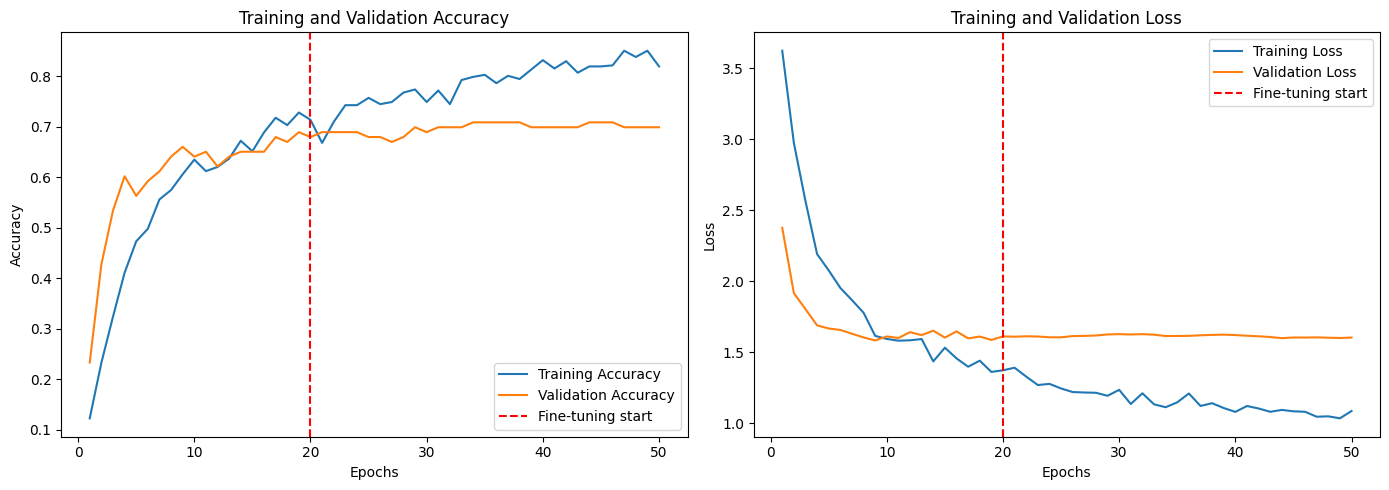

In [10]:
print('\nEvaluating the final model on the test set (single pass)...')
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy (single): {test_acc:.4f}')
print(f'Test Loss (single): {test_loss:.4f}')

# Plot combined history
acc = history_phase_a.history['accuracy'] + history_phase_b.history['accuracy']
val_acc = history_phase_a.history['val_accuracy'] + history_phase_b.history['val_accuracy']
loss = history_phase_a.history['loss'] + history_phase_b.history['loss']
val_loss = history_phase_a.history['val_loss'] + history_phase_b.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning start')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Generating predictions for the test dataset (single pass)...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step

Classification Report (single pass):
                       precision    recall  f1-score   support

      brown_swiss_cow       0.73      1.00      0.84         8
         dorper_sheep       0.89      0.89      0.89         9
            duroc_pig       0.75      0.60      0.67         5
          fresian_cow       0.71      0.56      0.62         9
        girolando_cow       0.89      0.80      0.84        10
indigenous_ankole_cow       0.89      0.89      0.89         9
      indigenous_goat       1.00      1.00      1.00         6
       indigenous_pig       0.60      0.60      0.60         5
           jersey_cow       0.80      0.57      0.67         7
         landrace_pig       0.60      0.33      0.43         9
      large_white_pig       0.64      1.00      0.78         7
         merino_sheep       0.78      0.88      0.82         8
         pietrain_pig       0.33      0.33

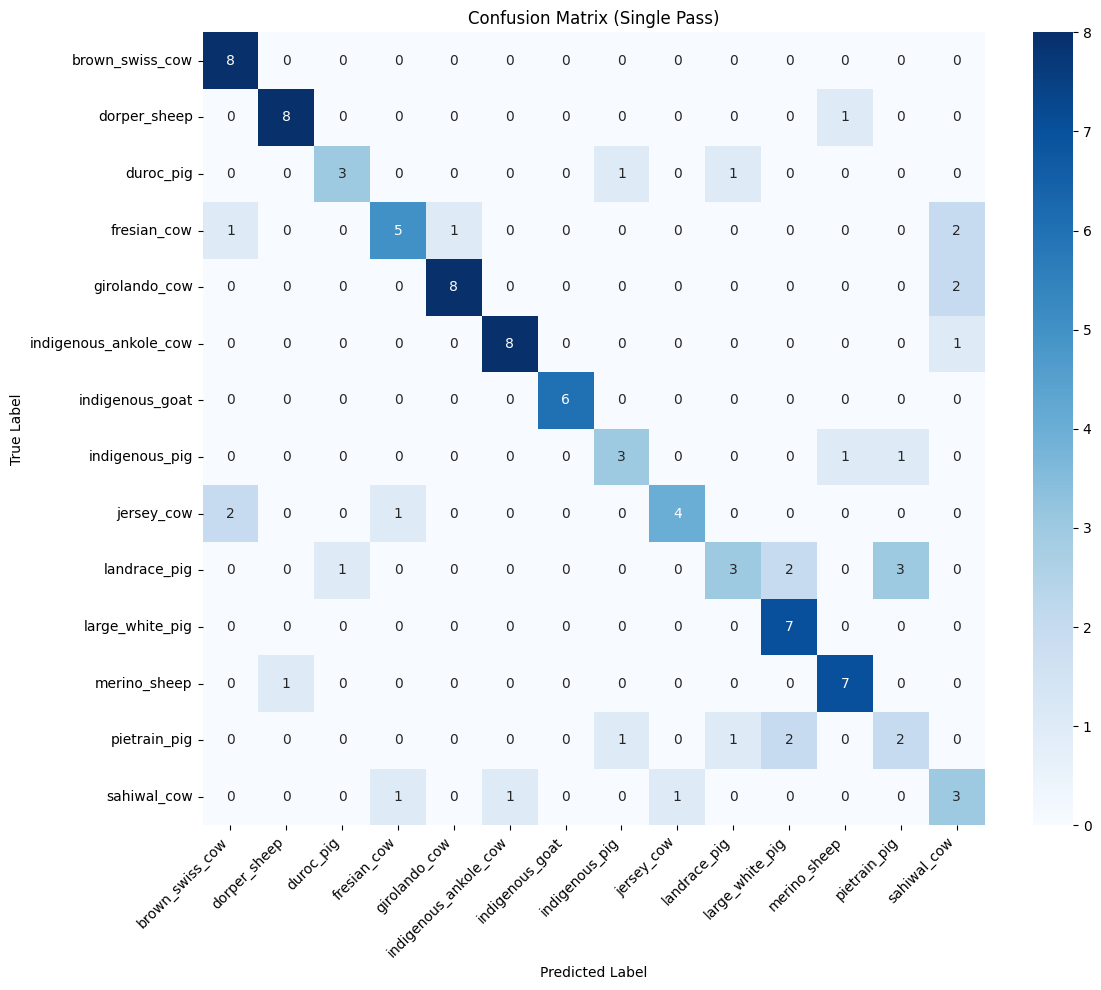


Performing Test-Time Augmentation (TTA) with 5 augmented versions...
Found 104 validated image filenames belonging to 14 classes.
TTA pass 1/5...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step
TTA pass 2/5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
TTA pass 3/5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 843ms/step
TTA pass 4/5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
TTA pass 5/5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step

Classification Report (TTA):
                       precision    recall  f1-score   support

      brown_swiss_cow       0.73      1.00      0.84         8
         dorper_sheep       0.89      0.89      0.89         9
            duroc_pig       0.75      0.60      0.67         5
          fresian_cow       0.67      0.67      0.67         9
        girolando_cow       1.00      0.80      0.89        10
indigenous_ankole_cow       0.89      0.89      0.89         9
      indigenous_goat       1.00      1.00      1.00         6
       indigenous_pig       0.50      0.60      0.55         5
           jersey_cow       0.83      0.71      0.77         7
         landrace_pig       0.75      0.33      0.46         9
      large_white_pig  

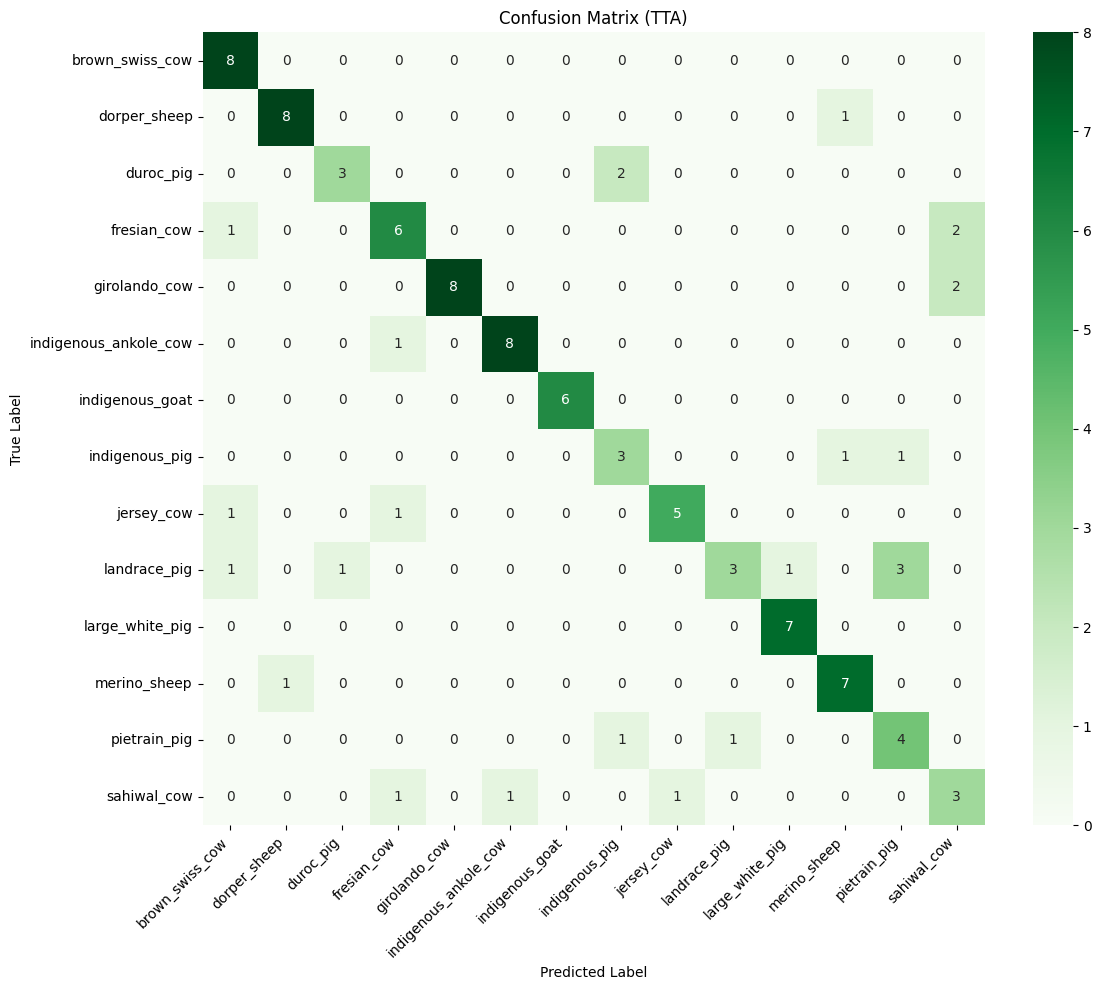

In [12]:
print('Generating predictions for the test dataset (single pass)...')
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print('\nClassification Report (single pass):')
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (original)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Single Pass)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test-Time Augmentation (TTA) for better generalization on rare classes
print('\nPerforming Test-Time Augmentation (TTA) with 5 augmented versions...')
tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    shear_range=5.0,
    channel_shift_range=10.0,
    fill_mode='nearest'
)

tta_generator = tta_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

n_tta = 5
tta_preds = []
for i in range(n_tta):
    print(f'TTA pass {i+1}/{n_tta}...')
    tta_generator.reset()
    pred = model.predict(tta_generator, verbose=1)
    tta_preds.append(pred)

avg_tta_probs = np.mean(tta_preds, axis=0)
y_pred_tta = np.argmax(avg_tta_probs, axis=1)

print('\nClassification Report (TTA):')
print(classification_report(y_true, y_pred_tta, target_names=class_names))

cm_tta = confusion_matrix(y_true, y_pred_tta)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TTA)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task
Save the livestock breed classification model in both ".keras" and ".h5" formats to "/content/drive/MyDrive/Data/livestock_resnet50_final.keras" and "/content/drive/MyDrive/Data/livestock_resnet50_final.h5", then conclude the project with a summary of the final results and model performance.

## Save Model in .keras and .h5 Formats

### Subtask:
Save the trained livestock classification model to Google Drive in both the native Keras (.keras) and legacy HDF5 (.h5) formats.


**Reasoning**:
I will save the trained model in both .keras and .h5 formats to the specified Google Drive path as instructed.



In [13]:
model_save_path_keras = '/content/drive/MyDrive/Data/livestock_resnet50_final.keras'
model_save_path_h5 = '/content/drive/MyDrive/Data/livestock_resnet50_final.h5'

# Save in native Keras format
model.save(model_save_path_keras)

# Save in legacy HDF5 format
model.save(model_save_path_h5)

print(f'Model successfully saved in .keras format at: {model_save_path_keras}')
print(f'Model successfully saved in .h5 format at: {model_save_path_h5}')

Model successfully saved in .keras format at: /content/drive/MyDrive/Data/livestock_resnet50_final.keras
Model successfully saved in .h5 format at: /content/drive/MyDrive/Data/livestock_resnet50_final.h5


# Task
Develop a livestock breed classification model using ResNet50 by loading images from "/content/drive/MyDrive/Data", implementing a two-phase training strategy (head training followed by fine-tuning), and evaluating performance using Test-Time Augmentation (TTA). Save the final trained model in .keras, .h5, and .tflite formats to "/content/drive/MyDrive/Data/livestock_resnet50_final" and provide a comprehensive project summary.

## Convert and Save TFLite Model

### Subtask:
Convert the trained ResNet50 classification model to the TensorFlow Lite (TFLite) format and save it to the specified path in Google Drive.


**Reasoning**:
I will convert the trained Keras model to the TFLite format using the TFLiteConverter and then save the resulting flatbuffer to the specified path in Google Drive.



In [14]:
import tensorflow as tf

# 1. Create a converter from the existing Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. Execute the conversion
tflite_model = converter.convert()

# 3. Define the target file path
tflite_save_path = '/content/drive/MyDrive/Data/livestock_resnet50_final.tflite'

# 4. Write the converted TFLite model to the designated path
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)

# 5. Confirm success
print(f'TFLite conversion successful. Model saved at: {tflite_save_path}')

Saved artifact at '/tmp/tmpwncudiui'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  132561311028176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311028944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311028368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311029520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311026640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311027216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311030864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311032208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311034128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132561311034320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325613110335